## CSCI S-89C Deep Reinforcement Learning, Summer 2020
### Section 8

## Semi-gradient 1-step TD Algorithm for Estimating $v_\pi$

We again consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" (denoted by 0) and "transplant" (denoted by 1). 

We assume that the Markov property holds. There are two additional states of the Markov Decision Process: "Posttransplant Life" (denoted by 19) and "Death" (which is denoted by 20 and combines so caled "Pretransplant Death" and "Posttransplant Death"). The only action availible in state "Posttransplant Life" is "wait" and "Death" is the terminal state with no actions. Assume that the length of an episode is T=50, unless it terminates earlier due to the transition to the absorbing state "Death."

We do not know the transition probabilities, but if a patient selects "wait," the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Death    
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Death    

If a patient selects "transplant" at Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there are two more possible transitions"  
5) "Posttransplant Life"->"Posttransplant Life" and "Posttransplant Life"->"Death"  


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state - assume that the patient gets these rewards on "exit" from the states, i.e. after we observe the corresponding stage. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).


Please consider statistics on 8,000 patients with ESLD saved in the 'ESLD_statistics.csv' file. Eeach row represents an episode (i.e. one patient) and the columns are the sequences of the patients' states and actions. This data were generated under the following policy:

$\pi(1|k)=0.02$ for $k\in\{1,2,3,4,5,6,7,8,9,10,11,12,13\}$;   
$\pi(1|14)=0.05$;   
$\pi(1|15)=0.10$;   
$\pi(1|16)=0.20$;   
$\pi(1|17)=0.40$;  
$\pi(1|18)=0.60$;  

which means that, for example, 5% of paients at stage 14 received a transplant.   
     
     
Let's approximate the state-values as follows:

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2 k+w_3 k^2\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_4\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})},$$

where ${\bf w}=(w_1,w_2,w_3,w_4)^T$. Please notice that $\hat{v}(\text{"Death"},{\bf w})=0$. 


### 1. Tabular 1-step TD

Let's run tabular 1-step TD first:

In [2]:
import random
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('data/ESLD_statistics.csv')
df.head(5)

,S0,A0,S1,A1,S2,A2,S3,A3,S4,A4,...,A45,S46,A46,S47,A47,S48,A48,S49,A49,S50
0,12,0,12,0,13,0,13,0,20,0,...,0,20,0,20,0,20,0,20,0,20
1,3,0,3,0,3,0,3,0,3,0,...,0,20,0,20,0,20,0,20,0,20
2,16,0,16,0,16,1,19,0,19,0,...,0,20,0,20,0,20,0,20,0,20
3,13,0,13,0,13,0,13,0,14,0,...,0,20,0,20,0,20,0,20,0,20
4,4,0,4,0,4,0,20,0,20,0,...,0,20,0,20,0,20,0,20,0,20


In [4]:
k = 2
states = df.values[k,0:-1:2]
states

array([16, 16, 16, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
      dtype=int64)

In [5]:
rewards = (states <= 18)*1 + (states == 19)*0.2
rewards

array([1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [6]:
k = 2
actions = df.values[k,1::2]
actions

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [7]:
def get_episode(df, k):
    states = df.values[k,0:-1:2]
    actions = df.values[k,1::2]
    rewards = (states <= 18)*1 + (states == 19)*0.2
    return [states, actions, rewards]

In [8]:
get_episode(df, 2)

[array([16, 16, 16, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
       dtype=int64),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int64),
 array([1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])]

In [9]:
alpha = 0.1
gamma = 0.97
T = 50
num_episodes = df.shape[0]
V = np.zeros(20)
V_history = V.reshape((20,1))
N = 0

for k in range(num_episodes):
    episode = get_episode(df, k)
    for t in range(0,T-1):
        N = N + 1
        S = episode[0][t]
        S1 = episode[0][t+1]
        R = episode[2][t]
        V[S-1] = V[S-1] + alpha*(R + gamma*V[S1-1] - V[S-1])
        if (int(N/100)*100==N):
            V_history = np.append(V_history, V.reshape((20,1)), axis=1)
        if S1==20:
            break

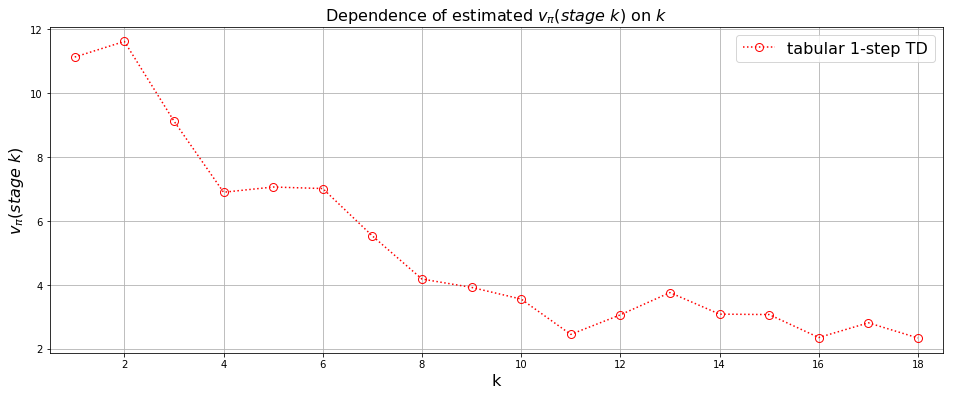

In [10]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V[0:18], linestyle=':', marker="o",mfc='none',color = "r", markersize=8, label='tabular 1-step TD')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

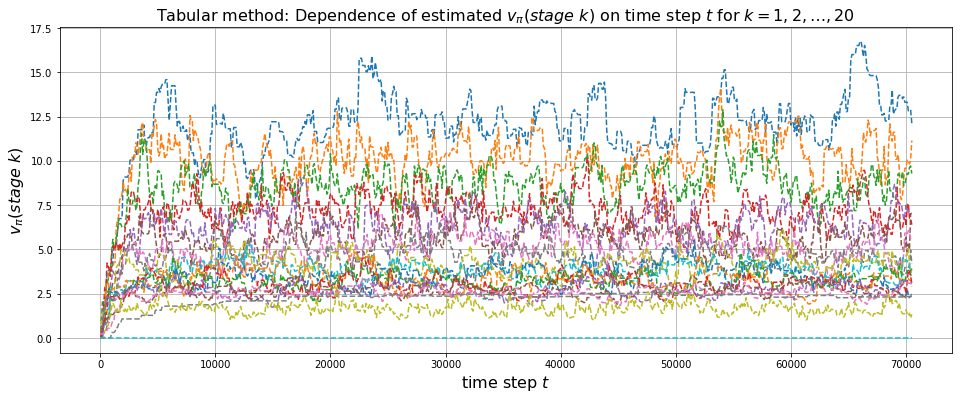

In [11]:
plt.figure(figsize=(16,6))
plt.plot(range(1,V_history.shape[1]*100,100),np.transpose(V_history), linestyle='--', marker=None, markersize=4)
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Tabular method: Dependence of estimated $v_\pi(stage\,\,k)$ on time step $t$ for $k=1,2,\ldots,20$',fontsize=16)
plt.grid(True)

### 2. Tabular 1-step TD with experience replay

In [12]:
np.random.seed(3455)

alpha = 1
gamma = 0.97
T = 50
num_episodes = df.shape[0]
V_replay = np.zeros(20)
num_epochs = 1000000
V_replay_history = V_replay.reshape((20,1))
N = 0

for i in range(num_epochs):
    N = N + 1
    k = np.random.randint(low=1, high=num_episodes, size=1)[0]
    episode = get_episode(df, k)
    t = np.random.randint(low=0, high=49, size=1)[0]
    S = episode[0][t]
    S1 = episode[0][t+1]
    R = episode[2][t]
    V_replay[S-1] = V_replay[S-1] + alpha/np.sqrt(N)*(R + gamma*V_replay[S1-1] - V_replay[S-1])
    if (int(N/100)*100==N):
        V_replay_history = np.append(V_replay_history, V_replay.reshape((20,1)), axis=1)

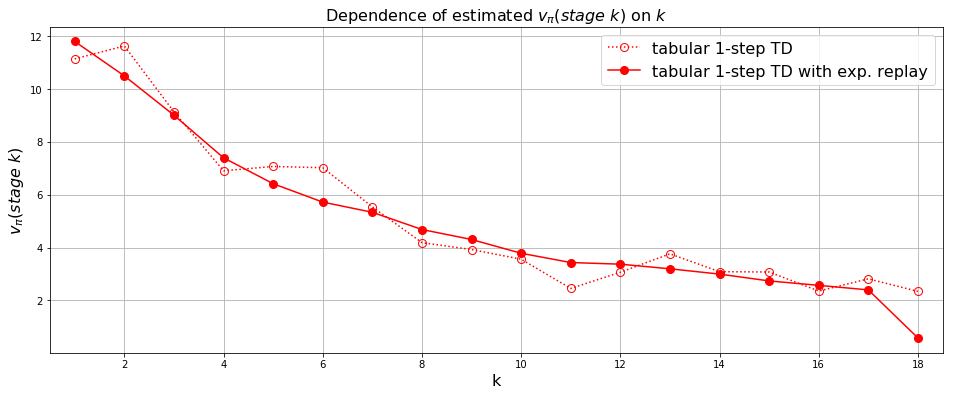

In [13]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V[0:18], linestyle=':', marker="o",mfc='none',color = "r", markersize=8, label='tabular 1-step TD')
plt.plot(range(1,19),V_replay[0:18], linestyle='-', marker="o",color = "r", markersize=8, label='tabular 1-step TD with exp. replay')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

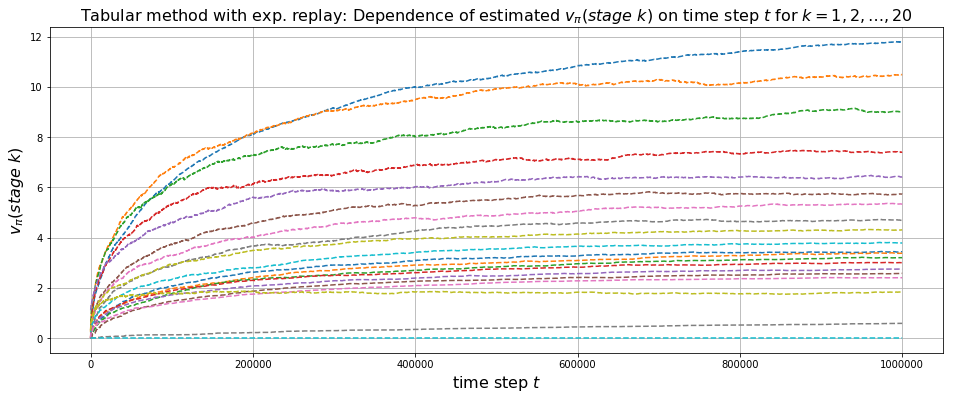

In [16]:
plt.figure(figsize=(16,6))
plt.plot(range(1,V_replay_history.shape[1]*100,100),np.transpose(V_replay_history), linestyle='--', marker=None, markersize=4)
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Tabular method with exp. replay: Dependence of estimated $v_\pi(stage\,\,k)$ on time step $t$ for $k=1,2,\ldots,20$',fontsize=16)
plt.grid(True)

### 3. Semi-gradient 1-step TD

We now initialize all weights at $0$ and run the semi-gradient 1-step TD algorithm for estimating $v_\pi$:

In [133]:
def v_hat0(k, w):
    v = (w[0] + w[1]*k + w[2]*k**2)*(k<=18) + w[3]*(k==19)
    return v

In [134]:
def dv_hat0(k, w):
    dv = [1, k, k**2, 0]*int(k<=18) + [0, 0, 0, 1]*int(k==19) + [0, 0, 0, 0]*int(k==20)
    return np.array(dv)

Let's approximate the state-values as follows:

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2 k+w_3 k^2\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_4\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})},$$

where ${\bf w}=(w_1,w_2,w_3,w_4)^T$. Please notice that $\hat{v}(\text{"Death"},{\bf w})=0$. 

In [167]:
alpha = 0.02
gamma = 0.97
T = 50
num_episodes = df.shape[0]
w0 = np.zeros(4)
w0_history = w0.reshape((4,1))
N = 0

for k in range(num_episodes):
    episode = get_episode(df, k)
    N = N + 1
    for t in range(0,T-1):
        N = N + 1
        S = episode[0][t]
        S1 = episode[0][t+1]
        R = episode[2][t]
        
        w0 = w0 + alpha/N*(R + gamma*v_hat0(S1,w0) - v_hat0(S,w0))*dv_hat0(S,w0)
        if (int(N/100)*100==N):
            w0_history = np.append(w0_history, w0.reshape((4,1)), axis=1)
        if S1==20:
            break

In [168]:
w0

array([ 2.93185676e+04,  1.83753255e+05, -1.37313982e+04,  1.00952962e-02])

In [170]:
V0_hat = [v_hat0(k,w0) for k in range(1,21)]
V0_hat

[199340.42433502057,
 341899.48466129584,
 456995.74858007545,
 544629.2160913597,
 604799.8871951484,
 637507.7618914413,
 642752.8401802389,
 620535.122061541,
 570854.6075353476,
 493711.29660165845,
 389105.1892604737,
 257036.28551179357,
 97504.58535561804,
 -89489.91120805312,
 -303947.2041792199,
 -545867.2935578823,
 -815250.1793440403,
 -1112095.861537693,
 0.010095296212180499,
 0.0]

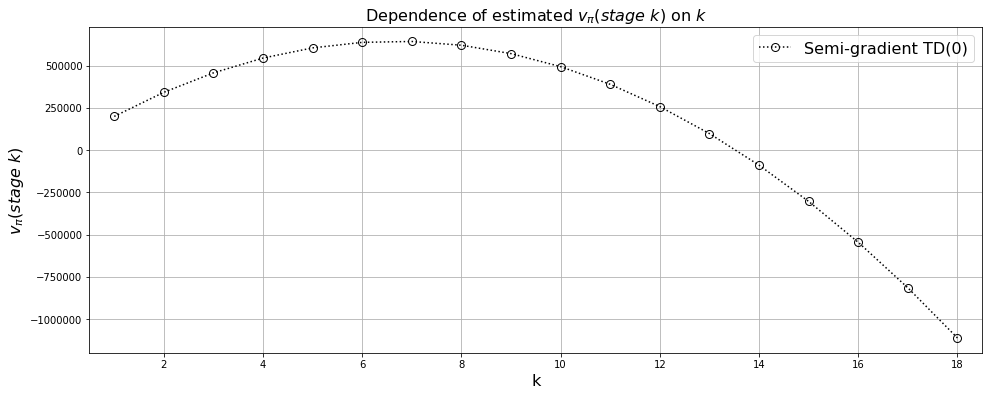

In [171]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V0_hat[0:18], linestyle=':', marker="o",mfc='none',color = "k", markersize=8, label='Semi-gradient TD(0)')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

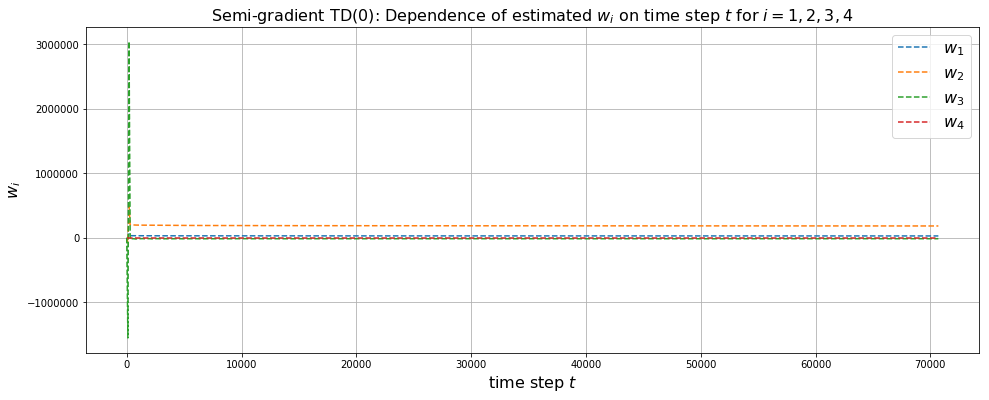

In [197]:
plt.figure(figsize=(16,6))
plt.plot(range(1,w0_history.shape[1]*100,100),w0_history[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(range(1,w0_history.shape[1]*100,100),w0_history[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(range(1,w0_history.shape[1]*100,100),w0_history[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(range(1,w0_history.shape[1]*100,100),w0_history[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('Semi-gradient TD(0): Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

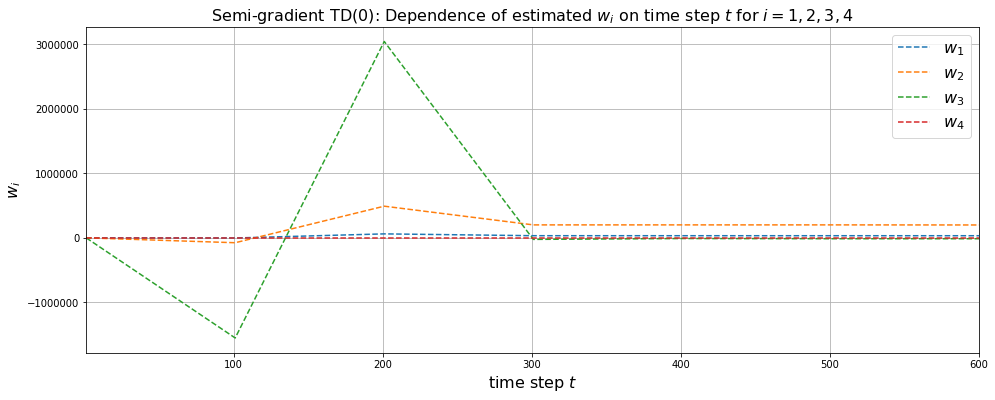

In [198]:
plt.figure(figsize=(16,6))
plt.plot(range(1,w0_history.shape[1]*100,100),w0_history[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(range(1,w0_history.shape[1]*100,100),w0_history[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(range(1,w0_history.shape[1]*100,100),w0_history[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(range(1,w0_history.shape[1]*100,100),w0_history[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('Semi-gradient TD(0): Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.xlim(1,600)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

In [200]:
w0

array([ 2.93185676e+04,  1.83753255e+05, -1.37313982e+04,  1.00952962e-02])

We now redefine weights in order to bring $w_1$, $w_2$, $w_3$, and $w_4$ on the same scale:

In [175]:
def v_hat(k, w):
    v = (w[0] + w[1]*k + 0.01*w[2]*k**2)*(k<=18) + w[3]*(k==19)
    return v

In [176]:
def dv_hat(k, w):
    dv = [1, k, 0.01*k**2, 0]*int(k<=18) + [0, 0, 0, 1]*int(k==19) + [0, 0, 0, 0]*int(k==20)
    return np.array(dv)

In [191]:
alpha = 0.1
gamma = 0.97
T = 50
num_episodes = df.shape[0]
w = np.zeros(4)
w_history = w.reshape((4,1))
N = 0

for k in range(num_episodes):
    episode = get_episode(df, k)
    N = N + 1
    for t in range(0,T-1):
        N = N + 1
        S = episode[0][t]
        S1 = episode[0][t+1]
        R = episode[2][t]
        w = w + alpha/np.sqrt(N)*(R + gamma*v_hat(S1,w) - v_hat(S,w))*dv_hat(S,w)
        if (int(N/100)*100==N):
            w_history = np.append(w_history, w.reshape((4,1)), axis=1)
        if S1==20:
            break

In [192]:
w

array([ 7.63291783,  0.01917818, -2.67981578,  1.40443627])

In [193]:
V_hat = [v_hat(k,w) for k in range(1,21)]
V_hat

[7.625297853352439,
 7.564081557919493,
 7.449268946966541,
 7.280860020493586,
 7.058854778500628,
 6.783253220987664,
 6.4540553479546965,
 6.0712611594017245,
 5.634870655328749,
 5.144883835735769,
 4.601300700622785,
 4.004121249989796,
 3.3533454838368035,
 2.648973402163807,
 1.8910050049708058,
 1.0794402922578001,
 0.2142792640247908,
 -0.7044780797282222,
 1.4044362721585621,
 0.0]

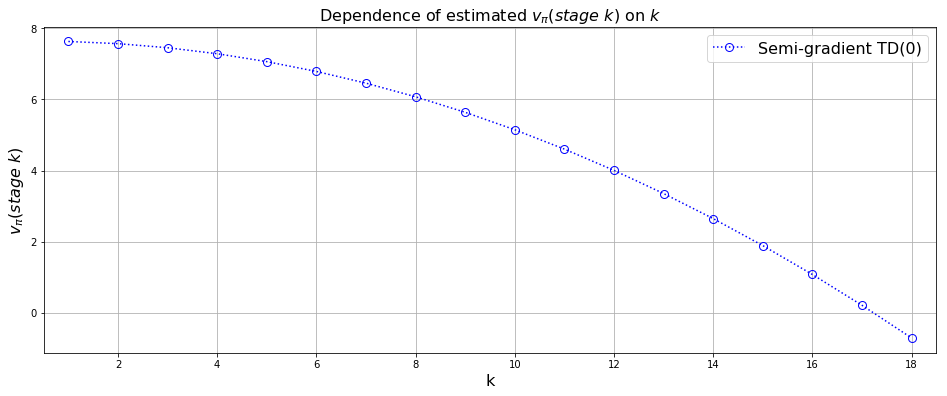

In [195]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V_hat[0:18], linestyle=':', marker="o",mfc='none',color = "b", markersize=8, label='Semi-gradient TD(0)')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

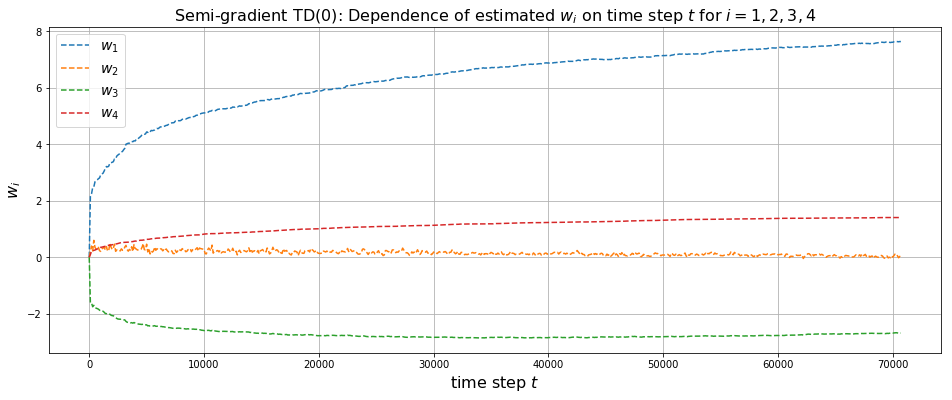

In [202]:
plt.figure(figsize=(16,6))
plt.plot(range(1,w_history.shape[1]*100,100),w_history[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(range(1,w_history.shape[1]*100,100),w_history[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(range(1,w_history.shape[1]*100,100),w_history[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(range(1,w_history.shape[1]*100,100),w_history[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('Semi-gradient TD(0): Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper left',fontsize=14)
plt.show()

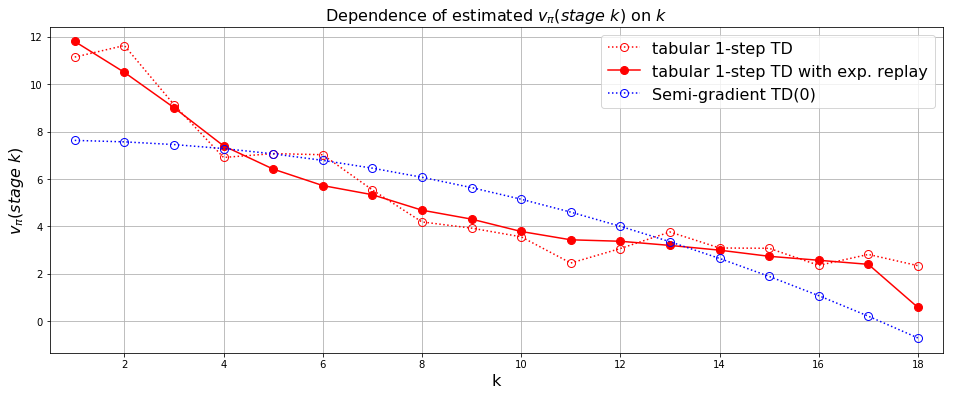

In [205]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V[0:18], linestyle=':', marker="o",mfc='none',color = "r", markersize=8, label='tabular 1-step TD')
plt.plot(range(1,19),V_replay[0:18], linestyle='-', marker="o",color = "r", markersize=8, label='tabular 1-step TD with exp. replay')
plt.plot(range(1,19),V_hat[0:18], linestyle=':', marker="o",mfc='none',color = "b", markersize=8, label='Semi-gradient TD(0)')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

### 4. Semi-gradient 1-step TD with experience replay

Let's repeat the semi-gradient 1-step TD algorithm using experience replay:

In [302]:
np.random.seed(3455)

alpha = 0.2
gamma = 0.97
T = 50
num_episodes = df.shape[0]
num_epochs = 5000000
w_replay = np.zeros(4)
w_replay_history = w_replay.reshape((4,1))
N = 0

for i in range(num_epochs):
    N = N + 1
    k = np.random.randint(low=1, high=num_episodes, size=1)[0]
    episode = get_episode(df, k)
    t = np.random.randint(low=0, high=49, size=1)[0]
    S = episode[0][t]
    S1 = episode[0][t+1]
    R = episode[2][t]
    w_replay = w_replay + alpha/(N**0.4)*(R + gamma*v_hat(S1,w_replay) - v_hat(S,w_replay))*dv_hat(S,w_replay)
    if (int(N/1000)*1000==N):
        w_replay_history = np.append(w_replay_history, w_replay.reshape((4,1)), axis=1)

In [303]:
w_replay

array([13.25843006, -1.42496216,  4.92207593,  1.78307528])

In [304]:
V_replay_hat = [v_hat(k,w_replay) for k in range(1,21)]
V_replay_hat

[11.882688658296404,
 10.605388776835964,
 9.426530413915081,
 8.34611356953375,
 7.364138243691976,
 6.480604436389756,
 5.695512147627089,
 5.008861377403979,
 4.420652125720423,
 3.930884392576419,
 3.5395581779719727,
 3.24667348190708,
 3.052230304381741,
 2.9562286453959548,
 2.9586685049497277,
 3.0595498830430525,
 3.258872779675931,
 3.556637194848367,
 1.7830752837754584,
 0.0]

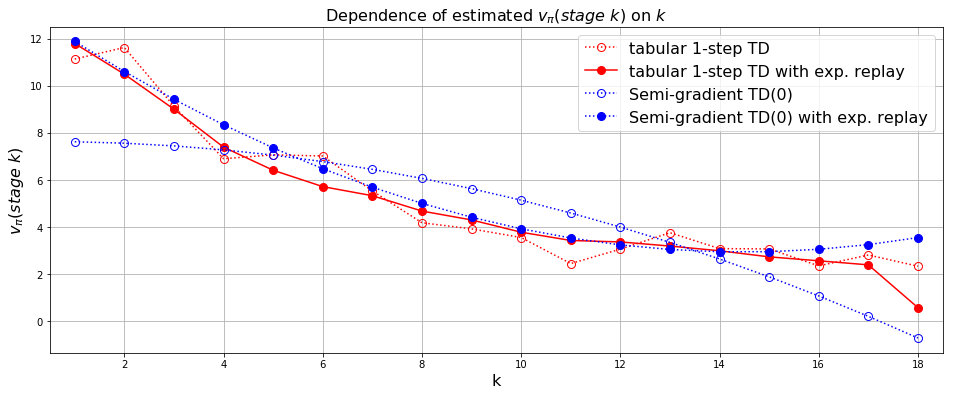

In [305]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V[0:18], linestyle=':', marker="o",mfc='none',color = "r", markersize=8, label='tabular 1-step TD')
plt.plot(range(1,19),V_replay[0:18], linestyle='-', marker="o",color = "r", markersize=8, label='tabular 1-step TD with exp. replay')
plt.plot(range(1,19),V_hat[0:18], linestyle=':', marker="o",mfc='none',color = "b", markersize=8, label='Semi-gradient TD(0)')
plt.plot(range(1,19),V_replay_hat[0:18], linestyle=':', marker="o",color = "b", markersize=8, label='Semi-gradient TD(0) with exp. replay')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

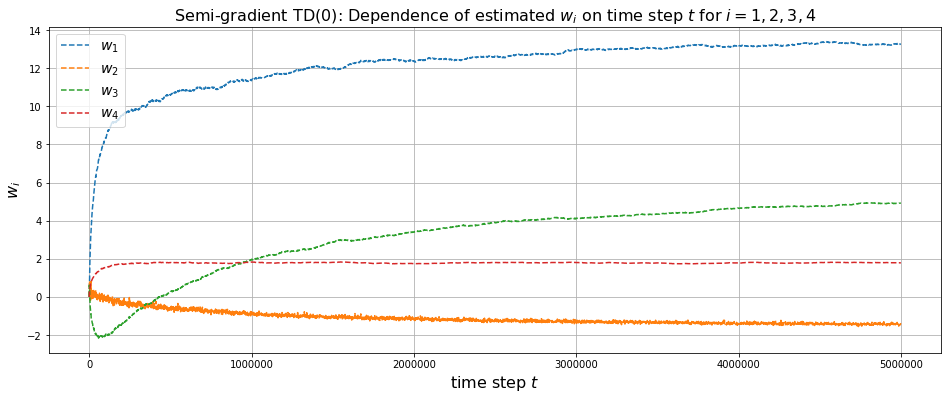

In [306]:
plt.figure(figsize=(16,6))
plt.plot(range(1,w_replay_history.shape[1]*1000,1000),w_replay_history[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(range(1,w_replay_history.shape[1]*1000,1000),w_replay_history[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(range(1,w_replay_history.shape[1]*1000,1000),w_replay_history[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(range(1,w_replay_history.shape[1]*1000,1000),w_replay_history[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('Semi-gradient TD(0): Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper left',fontsize=14)
plt.show()